# Script: The Demonstration of the Model Region

From the online bathymetry data of SalishSeaCast, we will be able to extract the mesh code of the region of our numerical model, which could be used in both the Methods part and the part where we need to integrate the upper layer biomass. 

In [ ]:
# Bathy file inspection

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 1. 获取数据

ds = nc.Dataset(
    "/data/nsoontie/MEOPAR/NEMO-forcing/grid/" "bathy_meter_SalishSea2.nc"
)

# print(ds)

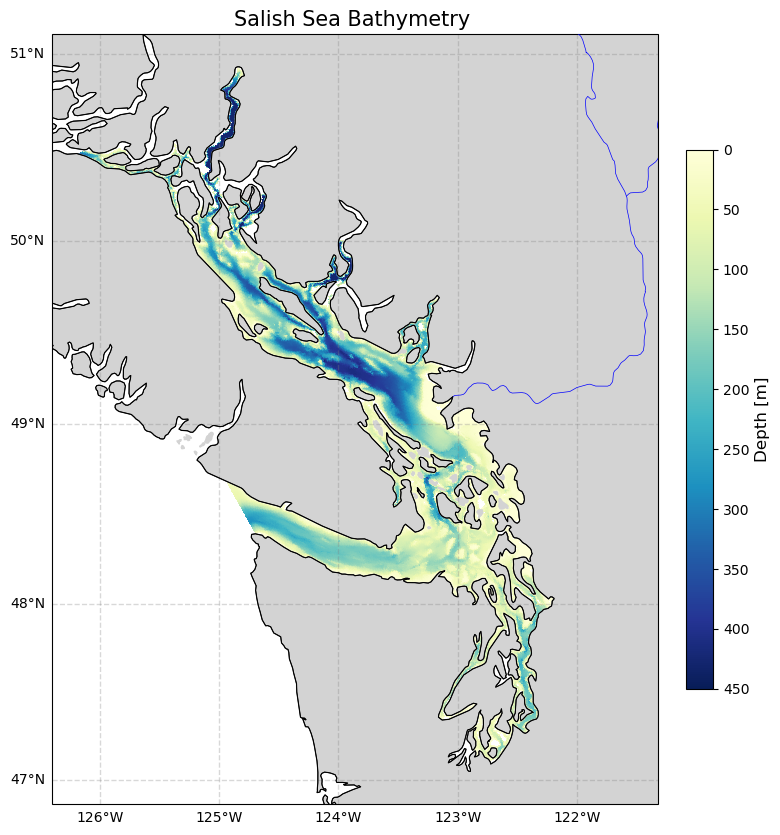

In [16]:
# Bathy plot

import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 1. 使用 netCDF4 打开本地文件
file_path = "/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc"
with nc.Dataset(file_path, 'r') as ds:
    # 提取变量
    lons = ds.variables['nav_lon'][:]
    lats = ds.variables['nav_lat'][:]
    bathy = ds.variables['Bathymetry'][:]

# 2. 创建画布与投影
fig = plt.figure(figsize=(12, 10))
# 使用 Mercator 投影在局部海域图上通常看起来更“正”一些
# 如果习惯等距圆柱投影，可以换回 ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.Mercator())

# 4. 绘制深度图
pcm = ax.pcolormesh(lons, lats, bathy, 
                    transform=ccrs.PlateCarree(),
                    cmap='YlGnBu', 
                    shading='auto',
                    vmin=0, vmax=450)

# 5. 添加并反转 colorbar
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('Depth [m]', fontsize=12)

# 将 colorbar 的 Y 轴反转
# 这样 0 (浅水) 就会在顶部，450 (深水) 就会在底部
cbar.ax.invert_yaxis()

# 4. 叠加地图特征
# 增加 LAND 填充以覆盖陆地区域的格点
# ax.add_feature(cfeature.LAND, facecolor='#e0e0e0', zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', zorder=3)

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor='lightgray')

ax.add_feature(land_10m, zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5, zorder=3)

# 5. 设置坐标和网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 6. 图例与标题
#cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
#cbar.set_label('Depth [m]', fontsize=12)
plt.title('Salish Sea Bathymetry ', fontsize=15)

# 设置显示范围 (根据 Salish Sea 范围自动或手动微调)
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

plt.show()

In [ ]:
# Save as .svg
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 读取数据 (保持不变)
file_path = "/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc"
with nc.Dataset(file_path, 'r') as ds:
    lons = ds.variables['nav_lon'][:]
    lats = ds.variables['nav_lat'][:]
    bathy = ds.variables['Bathymetry'][:]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# 1. 使用 rasterized=True 解决矢量渲染压力
# 2. 陆地填充 zorder 设高，并确保不是透明的
pcm = ax.pcolormesh(lons, lats, bathy, 
                    transform=ccrs.PlateCarree(),
                    cmap='YlGnBu_r', 
                    vmin=0, vmax=450,
                    rasterized=True) 

ax.add_feature(cfeature.LAND, facecolor='#d3d3d3', edgecolor='none', zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)

# 5. 设置坐标和网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Colorbar 处理
cbar = plt.colorbar(pcm, ax=ax, pad=0.03, shrink=0.7)
cbar.ax.invert_yaxis()

cbar.set_label('Depth [m]', fontsize=12)



# 强制设置显示范围，防止坐标漂移到空白区域
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])

# 保存文件，确保使用 dpi300 让 rasterized 的部分也清晰
plt.savefig("SalishSea_Bathy.svg", format='svg', bbox_inches='tight', dpi=300)
# plt.close() # 释放内存

Note that we also used the HRDPS wind forcing field. We should mark the range of the forcing field as well!

Figure saved as SalishSea_Bathy_with_Boundaries.svg


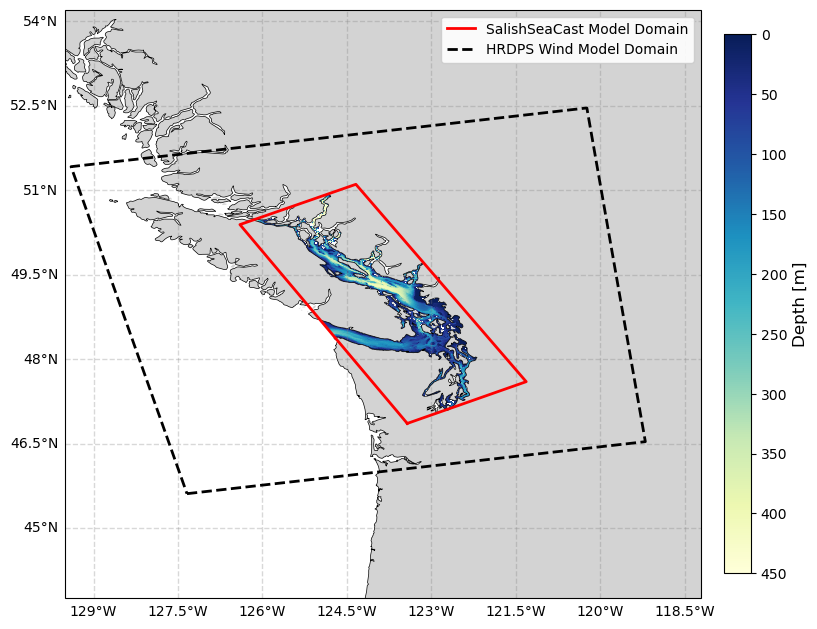

In [5]:
# Boundary_wind_and_bathy

import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np

# ==========================================
# 辅助函数：提取有效边界的四个角点
# ==========================================
def get_valid_boundary(lon_grid, lat_grid):
    """
    输入2D经纬度网格，去除(0,0)点，找出有效数据的四个角点，
    返回用于画线的 x 和 y 列表（闭合多边形）。
    """
    # 1. 创建掩码，过滤掉经纬度接近 0 的点 (防止无效点干扰)
    #    这里阈值设为 1e-3，足以过滤掉 0 值
    valid_mask = (np.abs(lon_grid) > 1e-3) & (np.abs(lat_grid) > 1e-3)
    
    # 2. 获取有效数据的索引范围
    #    np.where 返回的是有效值的 (row_indices, col_indices)
    rows, cols = np.where(valid_mask)
    
    if len(rows) == 0:
        raise ValueError("Grid contains only zeros or invalid coordinates!")

    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    # 3. 提取四个角点的经纬度 (基于 Grid Index 的四个角)
    #    注意：这里假设有效数据在 index 空间是连续的矩形块，这对大多数模型(NEMO/GEM)适用
    #    顺序：左下 -> 右下 -> 右上 -> 左上 -> 左下 (闭合)
    
    corners_idx = [
        (min_row, min_col), # 左下
        (min_row, max_col), # 右下
        (max_row, max_col), # 右上
        (max_row, min_col), # 左上
        (min_row, min_col)  # 回到起点
    ]
    
    b_lons = [lon_grid[r, c] for r, c in corners_idx]
    b_lats = [lat_grid[r, c] for r, c in corners_idx]
    
    return b_lons, b_lats

# ==========================================
# 主程序
# ==========================================

# 1. 读取 SalishSeaCast 深度数据
bathy_file = "/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc"
with nc.Dataset(bathy_file, 'r') as ds:
    ss_lons = ds.variables['nav_lon'][:]
    ss_lats = ds.variables['nav_lat'][:]
    bathy = ds.variables['Bathymetry'][:]

# 2. 读取 HRDPS 风场数据 (仅读取经纬度用于画边界)
wind_file = "/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m01d03.nc"
with nc.Dataset(wind_file, 'r') as ds:
    # 注意：有些 GEM 文件的经纬度变量名可能是 'lon', 'lat'，这里按你要求的 nav_lon 读取
    wind_lons = ds.variables['nav_lon'][:] 
    wind_lats = ds.variables['nav_lat'][:]

# 计算两个模型的边界坐标
ss_bound_x, ss_bound_y = get_valid_boundary(ss_lons, ss_lats)
wind_bound_x, wind_bound_y = get_valid_boundary(wind_lons, wind_lats)

# ==========================================
# 绘图部分
# ==========================================
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# A. 绘制深度图 (SalishSeaCast)
# ------------------------------------------------
pcm = ax.pcolormesh(ss_lons, ss_lats, bathy, 
                    transform=ccrs.PlateCarree(),
                    cmap='YlGnBu_r', 
                    vmin=0, vmax=450,
                    rasterized=True) 

# B. 绘制陆地和海岸线
# ------------------------------------------------
ax.add_feature(cfeature.LAND, facecolor='#d3d3d3', edgecolor='none', zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)

# C. 绘制模型边界框 (核心修改部分)
# ------------------------------------------------
# 1. SalishSeaCast 边界
ax.plot(ss_bound_x, ss_bound_y, 
        transform=ccrs.PlateCarree(), 
        color='red', linewidth=2, linestyle='-', zorder=10,
        label='SalishSeaCast Model Domain')

# 2. HRDPS 风场边界
ax.plot(wind_bound_x, wind_bound_y, 
        transform=ccrs.PlateCarree(), 
        color='black', linewidth=2, linestyle='--', zorder=10,
        label='HRDPS Wind Model Domain')

# D. 装饰 (Gridlines, Legend, Colorbar)
# ------------------------------------------------
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# 添加图例 (位置放在左上角或合适的位置)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Colorbar
cbar = plt.colorbar(pcm, ax=ax, pad=0.03, shrink=0.7)
cbar.ax.invert_yaxis()
cbar.set_label('Depth [m]', fontsize=12)

# 设置显示范围
# 策略：取两个模型范围的并集，或者以 SalishSea 为主，稍微外扩一点
# 这里我们以 SalishSeaCast 为中心，稍微zoom out一点以便看到风场边界（如果风场更大的话）
buff = 3.1 # 缓冲 5 度
ax.set_extent([
    np.min(ss_lons) - buff, np.max(ss_lons) + buff,
    np.min(ss_lats) - buff, np.max(ss_lats) + buff
])

# 保存
plt.savefig("SalishSea_Bathy_with_Boundaries.svg", format='svg', bbox_inches='tight', dpi=300)
print("Figure saved as SalishSea_Bathy_with_Boundaries.svg")
plt.show()